# Imports

In [20]:
import random

from qqdm.notebook import qqdm as qqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset, Dataset)
from torch.optim import Adam

# Loading and Data Functions

In [21]:
def numberize_labels(df: pd.DataFrame, label_col_key: str):
	label2num = {}
	num2label = {}
	for idx, label in enumerate(df[label_col_key].unique()):
		df[label_col_key].replace(label, idx, inplace=True)
		label2num[label] = idx
		num2label[idx]   = label
	
	return label2num, num2label


def IQR_normalization(dataframe: pd.DataFrame, normalizaiton: dict = None):
	norm_dict = {}
	if normalizaiton == None:
		for cat in dataframe.columns:
			#dict[category] = [max, 75percentile, mean, 25percentile, min]
			norm_dict[cat] = [0, 0, 0, 0, 0]
			norm_dict[cat][0] = dataframe[cat].max()
			norm_dict[cat][1] = dataframe[cat].quantile(0.75)
			norm_dict[cat][2] = dataframe[cat].mean()
			norm_dict[cat][3] = dataframe[cat].quantile(0.25)
			norm_dict[cat][4] = dataframe[cat].min()
	else:
		norm_dict = normalizaiton
	
	for cat in norm_dict:
		if norm_dict[cat][1] - norm_dict[cat][4] != 0:
			dataframe[cat] = (dataframe[cat] - norm_dict[cat][4]) / ( norm_dict[cat][1] - norm_dict[cat][4] )
		else:
			dataframe[cat].where(dataframe[cat] <= 1.0, 1.0, inplace=True)

	
	dataframe.where(dataframe <= 1.0, 1.0, inplace=True)

	if normalizaiton == None:
		return norm_dict


def load_and_clean_CSV(filename, cols_to_keep = None, normalization = None):
	data = pd.read_csv(filename)

	#Remove categorical columns
	if cols_to_keep == None:
		categorical_cols = [
			'Dst Port', 'Protocol', 'Timestamp', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
			'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 
			'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'ACK Flag Cnt', 'Active Max'
			# , 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt',
			# 'URG Flag Cnt', 'ECE Flag Cnt', 'Active Mean', 'Active Std', 'Active Min'
		]
		data = data.drop(categorical_cols, axis=1)
	else:
		for col in data.columns:
			if col not in cols_to_keep:
				data = data.drop([col], axis=1)
	
	#Remove 'Label' labels
	data = data[data['Label'] != 'Label']

	
	
	#Remove entries with null values
	data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

	#Numerize the labels
	label2num, num2label = numberize_labels(data, 'Label')
	print(f'Label : Key ->\n{label2num}')
	print(data['Label'].value_counts())

	#Remove label from dataframe prior to standardization
	labels = data['Label'].values
	data = data.drop(['Label'], axis=1)

	for col in data.columns:
		data[col] = pd.to_numeric(data[col])

	#Remove entries with Nan
	nan_mask = data.isin([np.nan, np.inf, -np.inf]).any(1)
	labels = labels[~nan_mask]
	data = data[~nan_mask]

	for col in data.columns:
		data[col] = pd.to_numeric(data[col])

	#Check for nulls
	null_counts = data.isin([np.nan, np.inf, -np.inf]).sum()
	for i in range(len(null_counts)):
		if null_counts[i] != 0:
			assert False,f'{data.columns[i]} has null values before standardization'

	#Standardization
	normalization = IQR_normalization(data, normalization)

	#Check for nulls
	null_counts = data.isin([np.nan, np.inf, -np.inf]).sum()
	for i in range(len(null_counts)):
		if null_counts[i] != 0:
			assert False,f'{data.columns[i]} has null values after standardization'

	#print('final columns:',list(data.columns))

	return data.values, labels, data.columns, label2num, num2label, normalization

def dataframe_to_tensor(data):
	return torch.from_numpy(data.values).float()

def extract_subsample(data, labels, label_idx, preferred_size=10000):
	balanced_size = min(np.bincount(labels).min(), preferred_size)
	label_mask = labels == label_idx
	#print(f'label mask len: {len(label_mask)}, data len: {len(data)}')
	data2 = data[label_mask]
	#return np.random.choice(data[labels == label_idx], replace=False, size=balanced_size)
	return data2[np.random.choice(len(data2), replace=False, size=balanced_size)]

## Dataset Class

In [22]:
class NumericalTensorDataset(Dataset):
	def __init__(this, data, labels):
		assert len(data) == len(labels),'Error in importing dataset; length of features and labels not equivalent.'

		this.data   = data.float()
		this.data   = this.data.cuda()
		this.labels = labels
	
	def __len__(this):
		return len(this.data)
	
	def __getitem__(this, idx):
		return [this.data[idx], this.labels[idx]]


# Load data

In [23]:
data, labels, columns_to_keep, label2num, num2label, normalization = load_and_clean_CSV('02-15-2018.csv')

Label : Key ->
{'Benign': 0, 'DoS attacks-GoldenEye': 1, 'DoS attacks-Slowloris': 2}
0    988050
1     41508
2     10990
Name: Label, dtype: int64


In [24]:
label_bin = np.bincount(labels)
print(label_bin)
data2 = extract_subsample(data, labels, 0, 90000)
print(data2)
print(len(data2))

[988050  41508  10990]
[[4.09346195e-02 5.00000000e-01 2.50000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 7.50000000e-01 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.39795262e-01 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.29019808e-05 2.50000000e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.44733524e-03 2.50000000e-01 5.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.38125690e-04 5.00000000e-01 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
10990


## Split data into benign and malicious datasets

In [25]:
benign_mask = labels == label2num['Benign']
benign_data = data[benign_mask]
benign_GT = labels[benign_mask]
malicious_data = data[~benign_mask]
malicious_GT   = labels[~benign_mask]
print(f'{len(benign_data)} benign entries and {len(malicious_data)} entries')

988050 benign entries and 52498 entries


In [26]:
#Create datasets
benign_dataset = NumericalTensorDataset(torch.from_numpy(benign_data), benign_GT)
malicious_dataset = NumericalTensorDataset(torch.from_numpy(malicious_data), malicious_GT)

del benign_data, benign_GT, malicious_data, malicious_GT, benign_mask

# Model

In [27]:
class WeirdTrafficNet(nn.Module):
	def __init__(self, in_dim):
		super(WeirdTrafficNet, self).__init__()

		#encoder_layer_dims = [in_dim, 31, 15, 6] #@30 epochs: train sep 7.7, 2/14 FTP 1.212, 2/14 SSH 0.461
		#encoder_layer_dims = [in_dim, 45, 25, 6] #@30 epochs: train sep 14.5, 2/14 FTP 1.437, 2/14 SSH 0.234
		#encoder_layer_dims = [in_dim, 45, 35, 6] #@30 epochs: train sep 11.2, 2/14 FTP 1.03, 2/14 SSH 0.49
		#encoder_layer_dims = [in_dim, 50, 35, 6] #@30 epochs: train sep 10.7, 2/14 FTP 0.529, 2/14 SSH 0.156
		encoder_layer_dims = [in_dim, 50, 35, 5] #@30 epochs: train sep 19.2, 2/14 FTP 2.04, 2/14 SSH 0.0006
		relu_inplace = True

		self.encoder = nn.Sequential(
			nn.Linear(encoder_layer_dims[0], encoder_layer_dims[1]),
			nn.ReLU(relu_inplace),
			nn.Linear(encoder_layer_dims[1], encoder_layer_dims[2]),
			nn.ReLU(relu_inplace),
			nn.Linear(encoder_layer_dims[2], encoder_layer_dims[3]),
			nn.ReLU(relu_inplace),
		)

		self.decoder = nn.Sequential(
			nn.Linear(encoder_layer_dims[3], encoder_layer_dims[2]),
			nn.ReLU(relu_inplace),
			nn.Linear(encoder_layer_dims[2], encoder_layer_dims[1]),
			nn.ReLU(relu_inplace),
			nn.Linear(encoder_layer_dims[1], encoder_layer_dims[0]),
			nn.Sigmoid()
			#nn.Tanh()
			#nn.ReLU()
		)

	def forward(self, x):
		x = self.encoder(x)
		x = self.decoder(x)
		return x

## Separation Index

$$
\textrm{Separation} = \frac{\textrm{median(target)}-\textrm{median(base)}}{\textrm{base}_{95\%}-\textrm{base}_{5\%}}
$$

In [28]:
def separation_index(base_losses: list, target_losses: list):
	return (-1*np.median(base_losses) + np.median(target_losses)) / ( np.percentile(base_losses, 95) - np.percentile(base_losses, 5) )
	#return abs(np.median(base_losses) - np.median(target_losses)) / ( np.max(base_losses) - np.min(base_losses) )

# Training

In [29]:
criterion = nn.MSELoss()

In [30]:
num_epochs = 30
batch_size = 1024
learning_rate = 1e-4

in_dim = len(data[0])
print(f'Training with {in_dim} features')

model = WeirdTrafficNet(in_dim).cuda()

optimizer = Adam(model.parameters(), lr=learning_rate)

benign_dataloader = DataLoader(benign_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
malicious_dataloader = DataLoader(malicious_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

loss_hist = []
epoch_loss_benign = []
epoch_loss_malicious = []

for epoch in range(num_epochs):
	model.train()
	loss_mean = []
	progbar = qqdm(benign_dataloader)
	for data in progbar:
		x = data[0]

		#Forward
		output = model(x)
		loss = criterion(output, x)
		loss_hist.append(loss.item())
		loss_mean.append(loss.item())

		#Backward
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		#Stats
		#loss_mean = np.mean(loss_mean)

		progbar.set_infos({
			'epoch': f'{epoch+1}',
			'loss': f'{np.mean(loss_mean):.6f}'
		})
	
	#Eval epoch
	model.eval()
	loss_mean = []

	#Eval benign data
	for data in benign_dataloader:
		x = data[0]

		#Forward
		output = model(x)
		loss = criterion(output, x)
		loss_mean.append(loss.item())
	
	benign_loss = np.mean(loss_mean)
	benign_losses = loss_mean

	loss_mean = []

	#Eval malicious data
	for data in malicious_dataloader:
		x = data[0]

		#Forward
		output = model(x)
		loss = criterion(output, x)
		loss_mean.append(loss.item())
	
	malicious_loss = np.mean(loss_mean)
	malicious_losses = loss_mean

	epoch_loss_benign.append(benign_loss)
	epoch_loss_malicious.append(malicious_loss)
	print(f'Benign loss: {benign_loss:.6f}')
	print(f'Malicious loss: {malicious_loss:.6f}')
	print(f'Separation index: {separation_index(benign_losses, malicious_losses):.6f}')

Training with 63 features


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  193.08it/s    1    0.120261                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.041525
Malicious loss: 0.068252
Separation index: 7.518071


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  193.14it/s    2    0.032542                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.026484
Malicious loss: 0.040822
Separation index: 4.970754


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  195.64it/s    3    0.023350                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.021209
Malicious loss: 0.036574
Separation index: 5.576170


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  196.60it/s    4    0.019833                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.018569
Malicious loss: 0.035777
Separation index: 6.581115


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  193.66it/s    5    0.017267                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.016216
Malicious loss: 0.035338
Separation index: 7.646355


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  196.00it/s    6    0.015464                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.014798
Malicious loss: 0.035281
Separation index: 8.530343


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  193.48it/s    7    0.014262                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.013656
Malicious loss: 0.031925
Separation index: 7.711075


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  196.34it/s    8    0.013089                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.012511
Malicious loss: 0.027218
Separation index: 7.051680


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  194.52it/s    9    0.011853                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.011247
Malicious loss: 0.024431
Separation index: 6.322558


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  193.81it/s   10    0.010892                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.010557
Malicious loss: 0.023954
Separation index: 6.772951


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  192.23it/s   11    0.010270                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.010009
Malicious loss: 0.023875
Separation index: 7.261097


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  192.15it/s   12    0.009736                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.009495
Malicious loss: 0.023622
Separation index: 7.269249


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  194.01it/s   13    0.009295                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.009117
Malicious loss: 0.023480
Separation index: 8.228397


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  191.62it/s   14    0.008960                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.008807
Malicious loss: 0.023517
Separation index: 8.396171


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  196.66it/s   15    0.008672                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.008559
Malicious loss: 0.023041
Separation index: 8.022154


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  192.33it/s   16    0.008471                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.008390
Malicious loss: 0.022662
Separation index: 8.180200


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  194.57it/s   17    0.008318                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.008250
Malicious loss: 0.022593
Separation index: 8.535637


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  192.67it/s   18    0.008191                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.008137
Malicious loss: 0.022356
Separation index: 8.448005


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  192.46it/s   19    0.008079                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.008037
Malicious loss: 0.021961
Separation index: 8.015900


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  196.22it/s   20    0.007981                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007938
Malicious loss: 0.021717
Separation index: 7.986630


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  193.78it/s   21    0.007889                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007844
Malicious loss: 0.021280
Separation index: 8.179583


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  193.52it/s   22    0.007808                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007772
Malicious loss: 0.021121
Separation index: 8.188422


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  191.39it/s   23    0.007738                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007706
Malicious loss: 0.020707
Separation index: 7.756159


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  191.03it/s   24    0.007674                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007639
Malicious loss: 0.020333
Separation index: 7.758709


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  194.52it/s   25    0.007610                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007571
Malicious loss: 0.019901
Separation index: 7.325724


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  192.77it/s   26    0.007531                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007486
Malicious loss: 0.019904
Separation index: 7.222518


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  190.94it/s   27    0.007449                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007417
Malicious loss: 0.019510
Separation index: 7.336598


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:04<00:00:00  193.99it/s   28    0.007368                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007260
Malicious loss: 0.018892
Separation index: 7.836537


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  190.65it/s   29    0.007152                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.007046
Malicious loss: 0.018557
Separation index: 7.710132


  Iters     Elapsed Time       Speed     epoch    loss                          
 965/965  00:00:05<00:00:00  191.37it/s   30    0.007014                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Benign loss: 0.006979
Malicious loss: 0.018348
Separation index: 7.244195


# Plot Loss

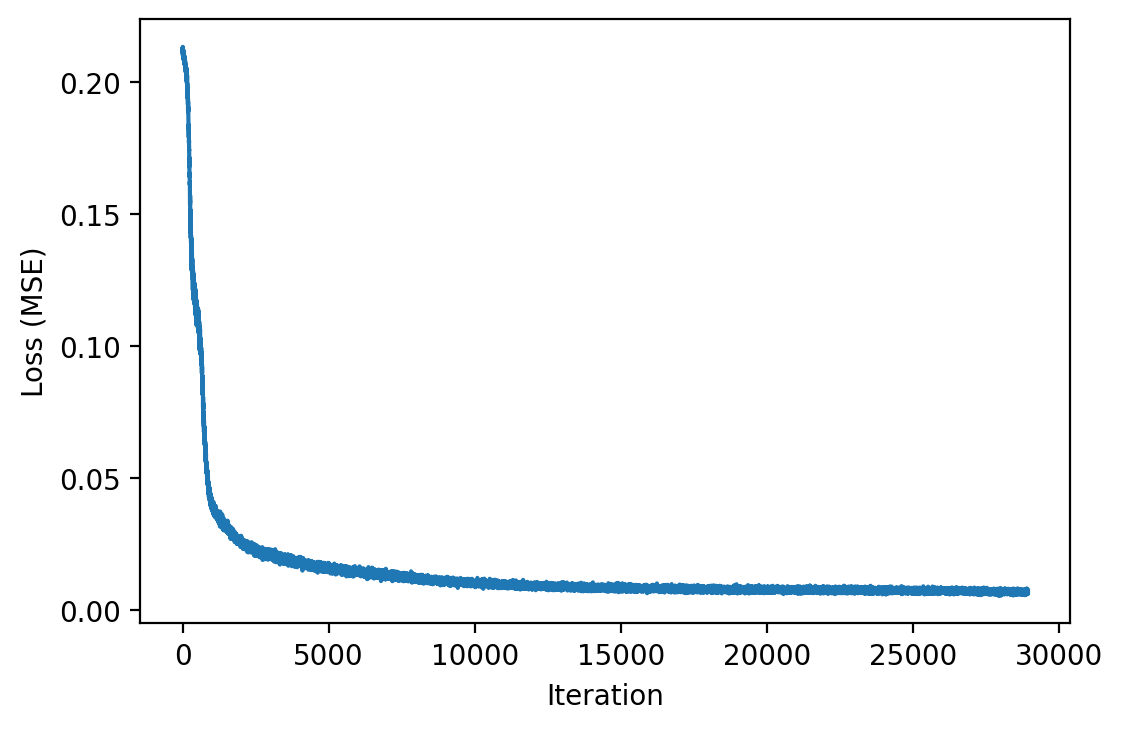

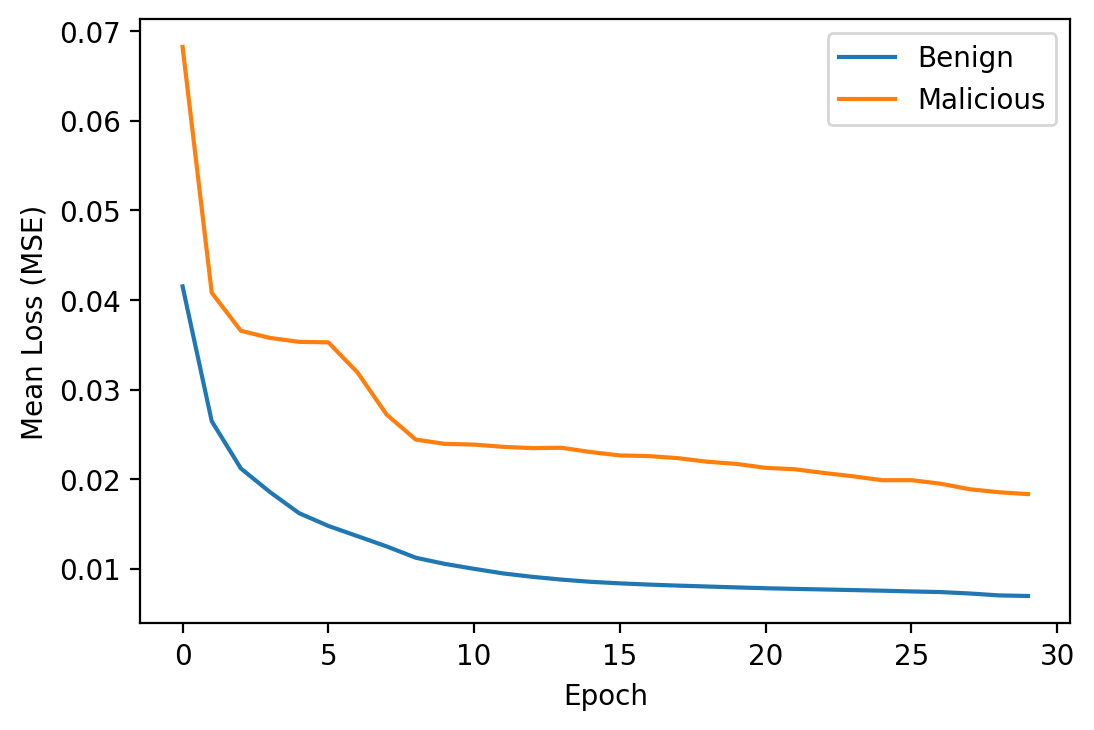

In [31]:
plt.figure(dpi=200)
plt.plot(loss_hist[:])
plt.ylabel('Loss (MSE)')
plt.xlabel('Iteration')
plt.show()

plt.figure(dpi=200)
plt.plot(epoch_loss_benign, label = 'Benign')
plt.plot(epoch_loss_malicious, label = 'Malicious')
plt.legend()
plt.ylabel('Mean Loss (MSE)')
plt.xlabel('Epoch')
plt.show()

# Testing Model on New Days

In [32]:
def test_model_on_day(model, criterion, columns_to_keep, filename, normalization):
	data, labels, columns, label2num, num2label, normalization = load_and_clean_CSV(filename, normalization=normalization)#, columns_to_keep)
	model.eval()

	str_labels = []
	losses = []
	seperations = []

	for label_idx in range(len(label2num)):
		loss_hist = []
		str_labels.append(num2label[label_idx])
		sub_data = extract_subsample(data, labels, label_idx, 5000)

		
		#Load data
		sub_data = torch.from_numpy(sub_data).float()
		sub_data = sub_data.cuda()

		#Forward
		for data_i in sub_data:
			# x = data
			output = model(data_i)
			loss = criterion(output,data_i)
			loss_hist.append(loss.item())

		#Stats
		losses.append(loss_hist)
	
	for label_idx in range(len(label2num)):
		if label_idx == label2num['Benign']:
			continue

		print(num2label[label_idx],'separation:', separation_index(losses[label2num['Benign']], losses[label_idx]))



	return str_labels, losses

# Test Model on 2/14

In [33]:
#good days: 2/14, 2/15, 2/21, 2/22, 2/23
day_labels, day_losses = test_model_on_day(model, criterion, columns_to_keep, '02-14-2018.csv', normalization)

Label : Key ->
{'Benign': 0, 'FTP-BruteForce': 1, 'SSH-Bruteforce': 2}
0    663808
1    193354
2    187589
Name: Label, dtype: int64
FTP-BruteForce separation: 0.16509459911343646
SSH-Bruteforce separation: 0.3599712783657468


(0.0, 0.185)

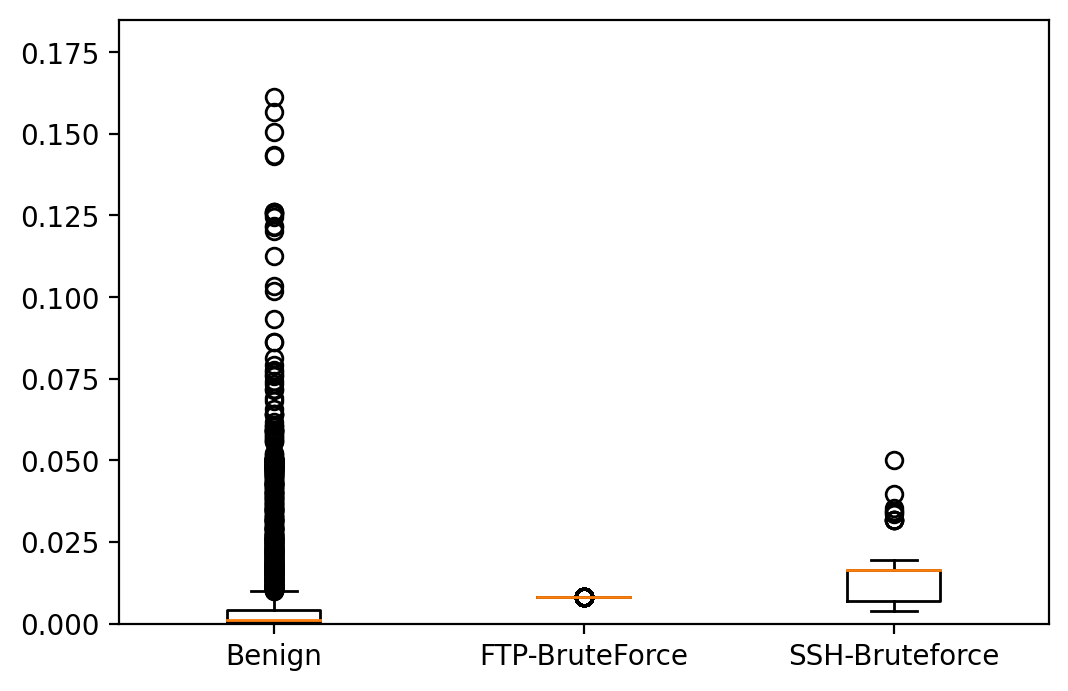

In [34]:
fig = plt.figure(dpi=200)
plt.boxplot(day_losses)
plt.xticks(list(range(1,len(day_losses)+1)), day_labels)
plt.ylim(0,0.185)

# Save Model

In [35]:
torch.save(model, './2018_model.pth')

In [36]:
# model = torch.load('./19-2-0006-50-35-5.pth')
# model.eval()

# Save Normalization Data

In [37]:
import pickle
with open('./normalization.data','wb') as f:
	pickle.dump(normalization, f, pickle.HIGHEST_PROTOCOL)